In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

In [4]:
test = 'PhaserotTest'
df_g = modules.utils.tabulate_last_perf(test=test,
                                      root=PERFLOG_DIR,
                                      extras=['times', 'baselines'])
if df_g is None:
    print('%s: no performance logs found' % test)
else:
    df_g = df_g.transpose() # so now cols are all, single
    display(df_g)

perf_var                                                            elapsed_time_cpu  \
case                                               times baselines                     
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:funclib... 10    10                 0.000480   
                                                         64                 0.000625   
                                                   20    64                 0.000790   
                                                   30    64                 0.000970   
                                                   40    64                 0.001130   
                                                   50    64                 0.001305   
                                                   10    100                0.000770   
                                                         128                0.000805   
                                                         256                0.001140   
                                                         512                0.001775   
                                                         1000               0.002930   
                                                   20    1000               0.005450   
                                                   30    1000               0.007940   
                                                   40    1000               0.010560   
                                                   50    1000               0.013050   
                                                   10    1024               0.003055   
                                                         2048               0.005575   
                                                         10000              0.026180   
generic:default:gnu                                10    10                 0.000380   
                                                   20    10                 0.000410   
                                                   30    10                 0.000440   
                                                   40    10                 0.000470   
                                                   50    10                 0.000500   
                                                   10    64                 0.000500   
                                                   20    64                 0.000660   
                                                   30    64                 0.000820   
                                                   40    64                 0.000970   
                                                   50    64                 0.001140   
                                                   10    100                0.000650   
                                                   20    100                0.000960   
                                                   30    100                0.001260   
                                                   40    100                0.001560   
                                                   50    100                0.001880   
                                                   10    128                0.000670   
                                                         256                0.000980   
                                                         512                0.001620   
                                                         1000               0.003380   
                                                   20    1000               0.006600   
                                                   30    1000               0.009510   
                                                   40    1000               0.012560   
                                                   50    1000               0.015670   
                                                   10    1024               0.002950   
                                                         2048               0.005450   
                                        

## Performance History

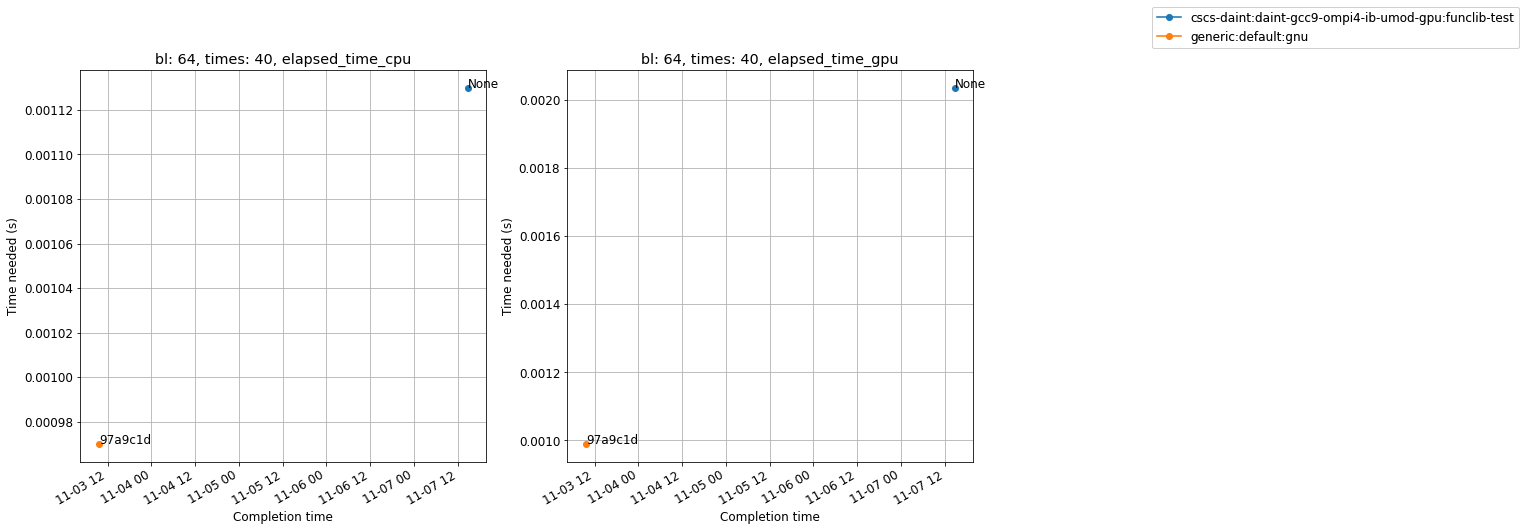

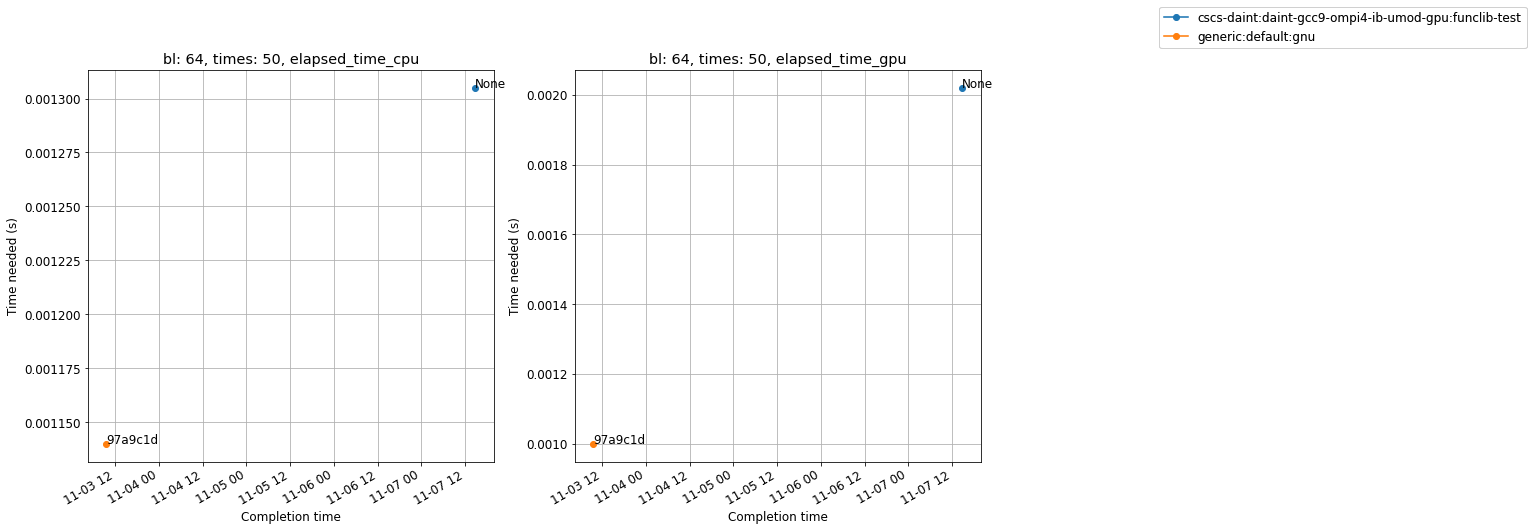

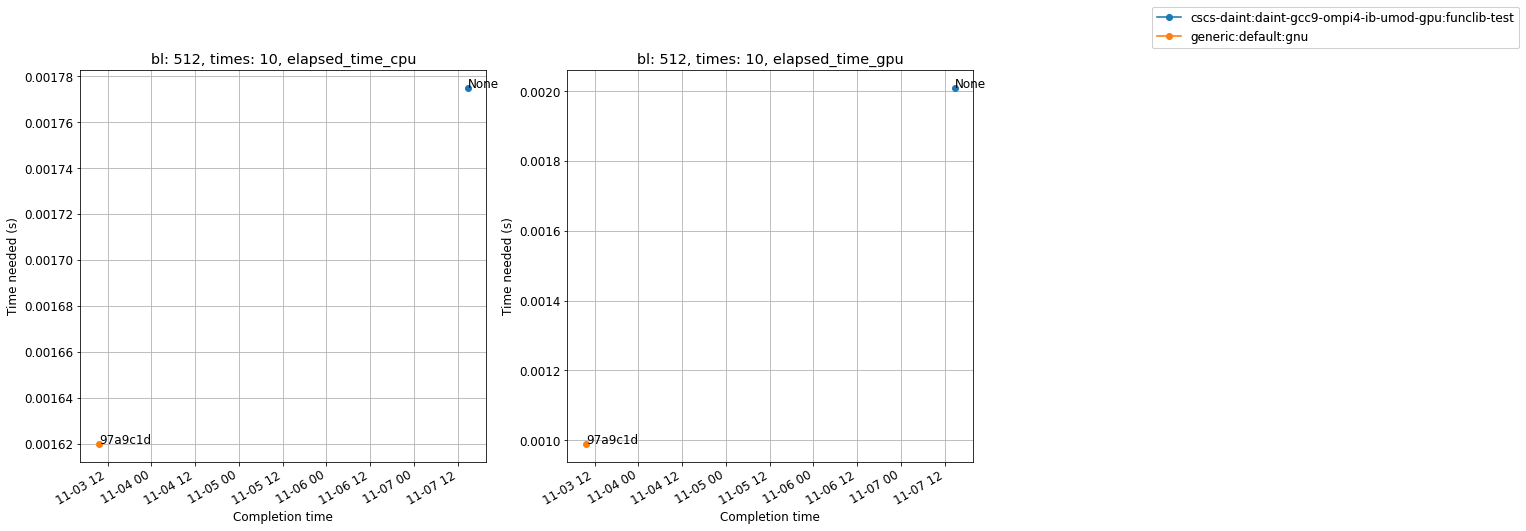

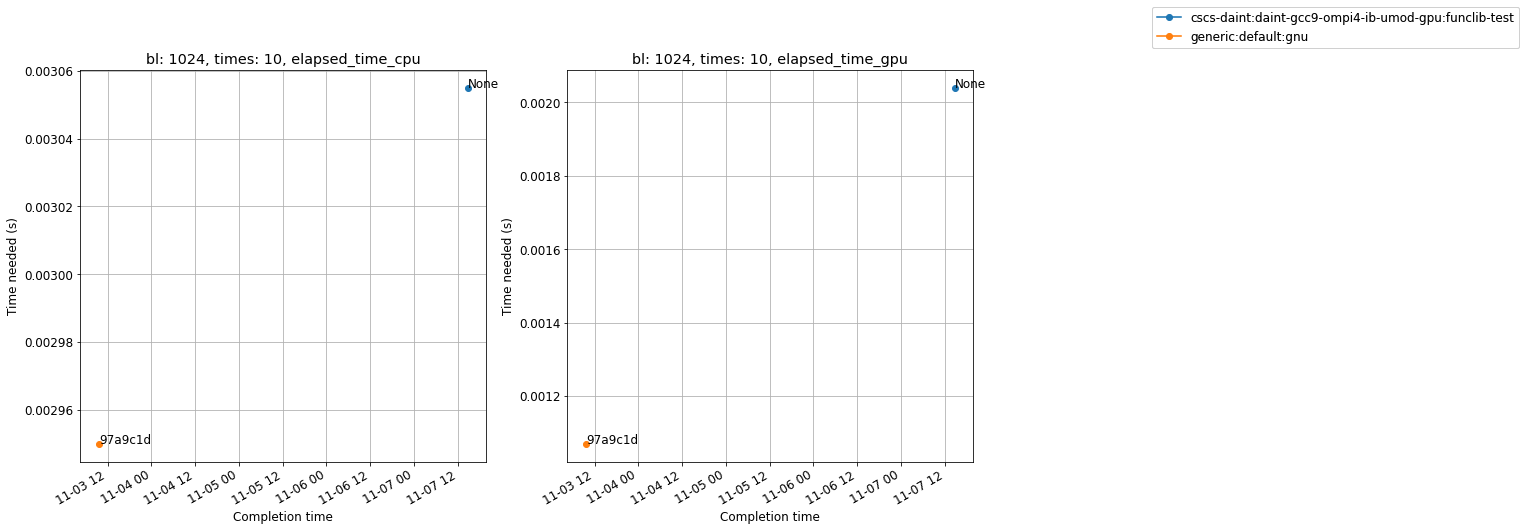

In [5]:
plt.rcParams.update({'font.size': 12})
perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=['times', 'baselines'], test=test)
if perf_records is None:
    print('%s: no performance logs found' % test)
else:
    configs = [(64, 10), (64, 20), (64, 30), (64, 40), (64, 50), (128, 10), (256, 10), (512, 10), (1024, 10), (2048, 10)]
    for baselines, n_times in configs:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
        for idx, perf_var in enumerate(perf_records['perf_var'].unique()):
            ax = axs[idx]
            for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
                data = data.loc[data['perf_var'] == perf_var]
                data = data.loc[data['times'] == n_times]
                data = data.loc[data['baselines'] == baselines]
                data.plot(ax=ax, x='completion_time', y='perf_value', style=['o-'], label=':'.join(spe), legend=None)

                # annotate points with git_ref:
                for x, y, ref in zip(data['completion_time'], data['perf_value'], data['git']):
                    if not pd.isnull(ref):
                        ax.annotate(ref[:7], (x, y))
            ax.set_title(f"bl: {baselines}, times: {n_times}, {perf_var}")
            ax.set_xlabel('Completion time')
            ax.set_ylabel('Time needed (s)')
            handles, labels = ax.get_legend_handles_labels()
            ax.grid()
            fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

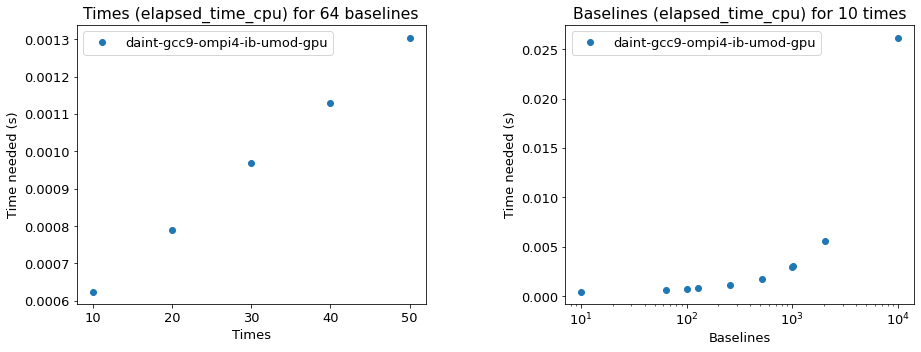

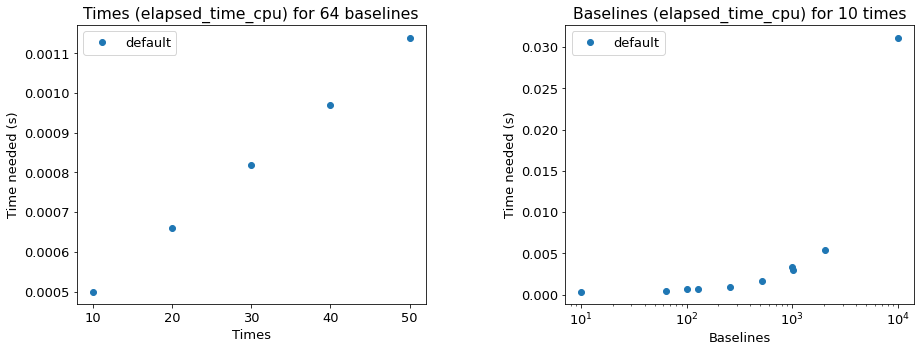

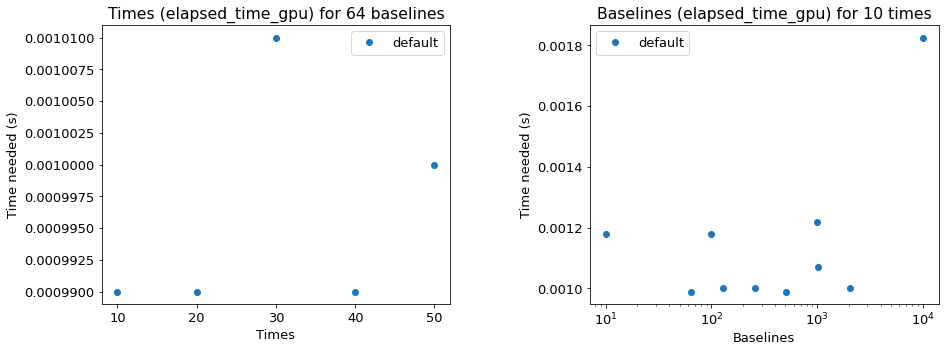

In [6]:
plt.rcParams.update({'font.size': 13})

perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, test=test, extras=['times', 'baselines'])
if perf_records is None:
    print('%s: no performance logs found' % test)
else:   
    for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
        
        for idx, perf_var in enumerate(data['perf_var'].unique()):
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
            plt.subplots_adjust(top = 0.98, bottom=0.01, hspace=0.9, wspace=0.4)
            
            df = data.loc[data['perf_var'] == perf_var]
            
            # plot time needed over times for fixed number of baselines
            baselines = 64
            df_times = df.loc[df['baselines'] == baselines]
            df_times.plot(ax=axs[0], x='times', y='perf_value', style=['o'], label=f"{df.partition.unique()[0]}")
            axs[0].set_title(f"Times ({perf_var}) for {baselines} baselines")
            axs[0].set_xlabel("Times")
            axs[0].set_ylabel("Time needed (s)")
            
            # plot time needed over baselines for fixed number of times
            times = 10
            df_bl = df.loc[df['times'] == times]
            df_bl.plot(ax=axs[1], x='baselines', y='perf_value', style=['o'], label=f"{df.partition.unique()[0]}")
            axs[1].set_xscale('log')
            axs[1].set_title(f"Baselines ({perf_var}) for {times} times")
            axs[1].set_xlabel("Baselines")
            axs[1].set_ylabel("Time needed (s)")
            
        plt.show()